# Reinforcement Learning: Learning to Play Tic-Tac-Toe with Q-Learning

## Introduction 
 
The goal of reinforcement learning is to use trial and error to learn the best action for each state. This can be expressed as the Q-value $Q(s, a)$ which is the expected utility of
choosing $a$ in $s$ and the following the current policy till a terminal state is reached. 

For small problems, the Q-value function can be expressed as a table. 
We implement here the table-based TD(0) as described in Chapter 6 of Sutton and Barto (2020). 

**Algorithm: Q-learning (off-policy TD control) for estimating $\pi^*$**

Parameters: step size $\alpha \in (0, 1]$, small $\epsilon > 0$, a discount factor $\gamma$

Initialize $Q(s, a) = 0$, for all $s \in S^+, a \in A(s)$

Loop for each episode:
  * Initialize $s$
  * Loop for each step of episode:
    *  Choose $a$ for $s$ (the state in the current step) using a policy derived from $Q$ (e.g., $\epsilon$-greedy)
    *  Take action $a$, observe the reward $r$ and the next state $s'$
    *  $Q(s, a) \leftarrow Q(s, a) + \alpha [r +  \gamma \max_a' Q(s', a') - Q(s, a)]$
    *  $s \leftarrow s'$
  * until $s$ is terminal

The idea is to make in every step $Q(s, a)$ a little more similar to 
the immediate reward plus the expected utility of the best action in the next state expressed as $r + Q(s', a')$. The algorithm is called temporal differencing since it used the 
difference between q-values at state $s$ and the next (i.e., later) state $s'$ which is also
called the TD-error.

Different to the description in Sutton and Batro (2020), we will implement the algorithm as an agent function that can interact with an environment. An example is shown in  AIMA Figure 22.8.

Also, there is no immediate reward in games like tic-tac-toe. A reward is only available when the game ends.

## Game Tree Size

First, we need to establish that the Q-table will fit in memory.

The game tree for tic-tac-toe is created by the first player with for the first move having 9 available actions, the next move has 8 and so on. The total number is 
$9! = 362880$. Note that not all can be reached in a game becaus the game ends when
one player wins. Also, there are many redundant paths leading to the same board 
resulting in fewer unique states (boards). 

The state space size can be estimated by all the ways we can choose $i = 1,2,3,...,9$ places from the board given by ${9 \choose i}$. Now we need to find all ways how we can choose half the symbols for player o which is given by ${i \choose \lfloor \frac{i}{2} \rfloor}$. 
Put together we get $\sum_{i=1}^9{{9 \choose i}{i \choose \lfloor \frac{i}{2} \rfloor}}$.

In [102]:
import math

print("level\tboards")
sum = 0

for i in range(1,9):
    sum += math.comb(9, i) * math.comb(i, math.floor(i/2))
    print(i, "\t", math.comb(9, i) , " x ", math.comb(i, math.floor(i/2)) , " = ",  math.comb(9, i) * math.comb(i, math.floor(i/2)))

sum

level	boards
1 	 9  x  1  =  9
2 	 36  x  2  =  72
3 	 84  x  3  =  252
4 	 126  x  6  =  756
5 	 126  x  10  =  1260
6 	 84  x  20  =  1680
7 	 36  x  35  =  1260
8 	 9  x  70  =  630


5919

This is still an upper bound since it contains some infeasible boards where both players have 3 in a row.

Next we can estimate how many entries a table to store the Q-values would have. There
is one entry for each state and action. 

In [103]:
print("level\tboards\tactions\tQ table entries")
sum = 0

for i in range(0,9):
    boards = math.comb(9, i) * math.comb(i, math.floor(i/2))
    actions = 9 - i
    print(i, "\t", 
          boards, "\t",
          actions, "\t",
          boards * actions)
    sum += boards * actions

sum

level	boards	actions	Q table entries
0 	 1 	 9 	 9
1 	 9 	 8 	 72
2 	 72 	 7 	 504
3 	 252 	 6 	 1512
4 	 756 	 5 	 3780
5 	 1260 	 4 	 5040
6 	 1680 	 3 	 5040
7 	 1260 	 2 	 2520
8 	 630 	 1 	 630


19107

This is an upper bound and therefor the Q-table should easily fit in memory and
learning all these values should not take too much time.

## The board and helper functions

I represent the board as a vector (in Python this is a list) of length 9. The values are `' ', 'x', 'o'`.

In [104]:
def empty_board():
    return [' '] * 9

board = empty_board()
board[0] = 'x'; board[3] = 'x'; board[6] = 'x'; board[1] = 'o'; board[4] = 'o'  
display(board)

['x', 'o', ' ', 'x', 'o', ' ', 'x', ' ', ' ']

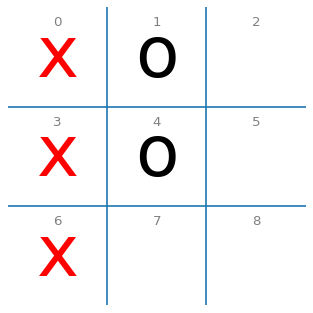

In [105]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def show_board(board, help = True, dpi = 40, colors = {' ': 'white', 'x': 'red', 'o': 'black'}):
    """Show the tic-tac-toe-board. help adds the array index, dpi changes the sice and 
    colors sets the colors"""
    
    # convert the vector representation into a 2-D numpy array (a matrix) for easier indexing
    b = np.array(board).reshape((3,3))

    with plt.rc_context({'figure.dpi': dpi}):
        fig = plt.matshow(np.zeros((3, 3)), cmap = ListedColormap(['w']))
    fig.axes.axis('off')
    
    # display grid
    plt.hlines([.5, 1.5], -.5, 2.5)
    plt.vlines([.5, 1.5], -.5, 2.5)

    # place xs and os
    for row in range(3):
        for col in range(3):
            plt.text(row, col, b[col, row], 
                 fontsize = 64, 
                 color = colors[b[col, row]],
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
        
    # show index numbers
    if help:
        for row in range(3):
            for col in range(3):
                plt.text(col, row - .35, col + 3 * row, 
                     fontsize = 12, 
                     color = 'gray',
                     horizontalalignment = 'center',
                     verticalalignment = 'center')
        
        
    plt.show()
    
show_board(board)

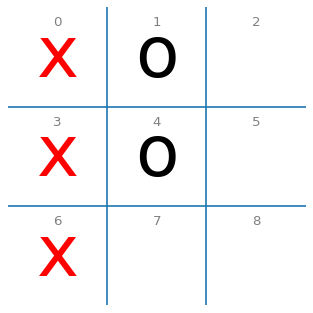

Win? x



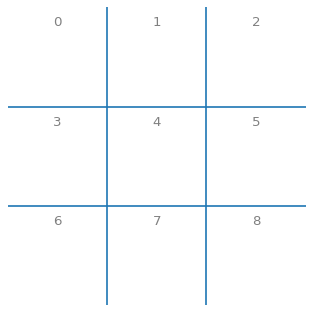

Win? n


In [106]:
def check_board(board):
    """check the board and return one of x, o, d (draw), or n (for next move)"""

    board = np.array(board).reshape((3,3))
   
    diagonals = np.array([[board[i][i] for i in range(len(board))], 
                          [board[i][len(board)-i-1] for i in range(len(board))]])
    
    for a_board in [board, np.transpose(board), diagonals]:
        for row in a_board:
            if len(set(row)) == 1 and row[0] != ' ':
                return row[0]

    # check for draw
    if(np.sum(board == ' ') < 1):
        return 'd'
    
    return 'n'

show_board(board)
print('Win? ' + check_board(board))

print()
show_board(empty_board())
print('Win? ' + check_board(empty_board()))

In [107]:
def is_terminal(board):
    return check_board(board) != 'n'

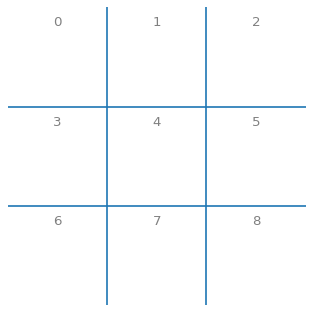


New state after placing an x at position 4:


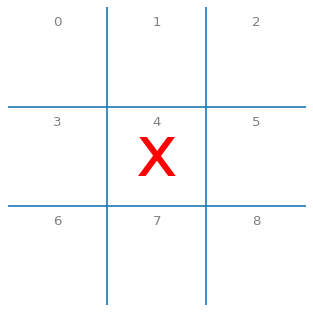

In [108]:
def result(state, player, action):
    """Add move to the board."""
    
    if(state[action] != ' '):
        print("Error: Illegal move!")
        
    # making a deep copy is very important so you do not overwrite other 
    # states in your search tree. 
    state = state.copy()
    
    # Note: x.copy() makes a deep copy of a Python list. For a numpy array/matrix you 
    #       need to use numpy.copy() instead!
    
    state[action] = player
  
    return state

show_board(empty_board())

print()
print("New state after placing an x at position 4:")
show_board(result(empty_board(), 'x', 4))

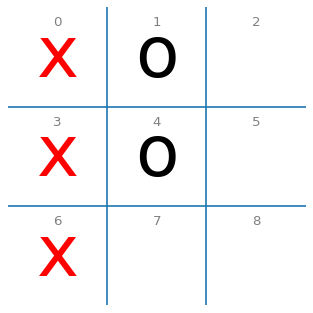

[2, 5, 7, 8]

In [109]:
def actions(state):
    """return possible actions as a vector of indices"""
    return np.where(np.array(state) == ' ')[0].tolist()

show_board(board)
actions(board)

## Finding a Policy using Q-Learning

Define the reward for a board and a player. Remember, reward is only defined in this game for the terminal state so we return `None` otherwise.

In [110]:
def reward (board, player):
    """Return the reward for the board position."""
    
    winner = check_board(board)
    
    if winner == 'n':
        return None
    elif winner == player:
        return 1
    elif winner == 'd':
        return 0
    else:
        return -1

We will use argmax with randomly breaking ties.

In [111]:
def argmax_rand(b):
    return np.random.choice(np.flatnonzero(b == np.max(b)))

In [112]:
class QAgent:
    def __init__(self, epsilon = 0.1, alpha = 0.1, gamma = 0.9, player = 'x'):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.player = player
        self.reset()
        
    def reset(self):
        self.Q = dict() # Q-table, empty means all entries are initially 0
        self.s = None
        self.a = None
        if DEBUG:
                print("Resetting QAgent")

    def play(self, s, r, player):
        global DEBUG
        
        if player != self.player:
            print("Error: I was not trained to play as", player)
            return None

        # Update Q-table with final reward, no more actions possible
        if (r != None):
            # we directly set the Q-value with to the final reward
            self.Q[(tuple(self.s), self.a)] = r
            if DEBUG:
                print("Updating Q-table for state", self.s, "and action", self.a, "with reward", r)

            self.s = None
            self.a = None
            return None

        
        # Update Q-table while game is not over
        
        # We use in the update a zero immediate reward 
        r = 0
        s_prime = s

        if self.s is not None and self.a is not None:
            max_Q_sp_a = np.max([self.Q.get((tuple(s_prime), x), 0) for x in actions(s_prime)])
            Q_sa = self.Q.get((tuple(self.s), self.a), 0)
            self.Q[(tuple(self.s), self.a)] = Q_sa + self.alpha * (r + self.gamma * max_Q_sp_a - Q_sa)

            if DEBUG:
                print("Updating Q-table for state", self.s, "and action", self.a, "to", self.Q[(tuple(self.s), self.a)])


        # Determine new action using epsilon-greedy strategy
        if np.random.uniform() < self.epsilon:
            # random action
            a = np.random.choice(actions(s))
            if DEBUG:
                print("Chosen random action:", a)
        else:
            # greedy action (best action given current Q-values)
            a = actions(s)[argmax_rand([self.Q.get((tuple(s), x), 0) for x in actions(s)])]
            if DEBUG:
                print("Chosen greedy action:", a)

        # remember state and action
        self.s = s_prime
        self.a = a

        return a

## Experiments

### The Environment and a Random Baseline Player

Implement the environment that calls the agent function for players x and o. 

The agent function gets the following percepts from the environment:
* the state (board) 
* the immediate reward (r)
* what player it should play

The agent function needs to return a valid move as the action.

**Note:** In this game, there is no immediate reward till the game is done. 
We call the agent function when the game is done with the reward.

In [113]:
def switch_player(player, x, o):
    if player == 'x':
        return 'o', o
    else:
        return 'x', x

def play(x, o, N = 100):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {'x': 0, 'o': 0, 'd': 0}
    
    for i in range(N):
        board = empty_board()
        player, fun = 'x', x
        
        while True:
            a = fun(board, None, player)
            board = result(board, player, a)
            
            win = check_board(board)   # returns the 'n' if the game is not done.
            
            if win != 'n':
                results[win] += 1
                # show agents final reward
                x(board, reward(board, 'x'), 'x')
                o(board, reward(board, 'o'), 'o')
                break
            
            player, fun = switch_player(player, x, o)   
    
    return results

Implement a completely randomized player agent can be used as a weak baseline.

In [114]:
def random_player(board, r, player = None):
    """Simple player that chooses a random empty square (equal probability of all permissible actions). 
    player is unused."""
    if (r != None):
        return None    
    
    return np.random.choice(actions(board))

### Random vs. Random

In [115]:
# timeit: n ... how many times to execute the statement, 
#         r ... how many times to repeat the timer (default 5)

%time display(play(random_player, random_player, N = 100))

{'x': 56, 'o': 26, 'd': 18}

CPU times: user 34.9 ms, sys: 55.9 ms, total: 90.7 ms
Wall time: 29.6 ms


_Note:_ It looks like the first player (x) has an advantage!

## Q-Learning Agent vs. Random

The agent learns for every game that it plays. 
We start with the first 100 games to see how bad it initially is.
For the final 1000 games, we set $\epsilon = 0$ so the 
agent only makes greedy moves.

The hyperparameters $\epsilon$ and $\alpha$ could be tuned.


### Train a q-learning agent for playing o.

In [116]:
print("Random vs. q-Learning:")

DEBUG = False

qplayer_o = QAgent(player = 'o', epsilon = 0.2, alpha = 0.2)
qplayer_o.reset()

print("Initially, the performance is not better than a random player!")
display(play(random_player, qplayer_o.play, N = 100))

print("Play to learn how to play against a random player.")
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))
display(play(random_player, qplayer_o.play, N = 1000))

print("Set epsilon to zero to make the agent greedy and play again:")
qplayer_o.epsilon = 0.0
display(play(random_player, qplayer_o.play, N = 1000))

print("Q-table size:", len(qplayer_o.Q))
qplayer_o.Q

Random vs. q-Learning:
Initially, the performance is not better than a random player!


{'x': 57, 'o': 35, 'd': 8}

Play to learn how to play against a random player.


{'x': 494, 'o': 386, 'd': 120}

{'x': 326, 'o': 569, 'd': 105}

{'x': 225, 'o': 662, 'd': 113}

{'x': 202, 'o': 693, 'd': 105}

{'x': 174, 'o': 723, 'd': 103}

{'x': 161, 'o': 731, 'd': 108}

{'x': 154, 'o': 719, 'd': 127}

{'x': 131, 'o': 755, 'd': 114}

{'x': 143, 'o': 742, 'd': 115}

{'x': 118, 'o': 761, 'd': 121}

Set epsilon to zero to make the agent greedy and play again:


{'x': 5, 'o': 908, 'd': 87}

Q-table size: 4731


{((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'x'), 6): 0.2505158312830592,
 (('x', ' ', ' ', ' ', ' ', ' ', 'o', ' ', 'x'), 2): -1,
 (('x', ' ', 'o', 'x', ' ', ' ', 'o', ' ', 'x'), 4): 1,
 ((' ', ' ', ' ', ' ', 'x', ' ', ' ', ' ', ' '), 2): 0.15551709696000002,
 (('x', ' ', 'o', ' ', 'x', ' ', ' ', ' ', ' '), 7): -0.8,
 (('x', ' ', 'o', ' ', 'x', 'x', ' ', 'o', ' '), 1): 0.0,
 (('x', 'o', 'o', ' ', 'x', 'x', 'x', 'o', ' '), 8): -1,
 ((' ', ' ', ' ', 'x', ' ', ' ', ' ', ' ', ' '), 5): 0.2535090550711592,
 (('x', ' ', ' ', 'x', ' ', 'o', ' ', ' ', ' '), 7): 0.0,
 (('x', 'x', ' ', 'x', ' ', 'o', ' ', 'o', ' '), 4): -0.18000000000000002,
 (('x', 'x', ' ', 'x', 'o', 'o', ' ', 'o', 'x'), 6): -1,
 ((' ', 'x', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 7): 0.027287811527185016,
 ((' ', 'x', ' ', ' ', ' ', 'x', ' ', 'o', ' '), 4): 0.0,
 ((' ', 'x', ' ', 'x', 'o', 'x', ' ', 'o', ' '), 0): 0.18000000000000002,
 (('o', 'x', ' ', 'x', 'o', 'x', 'x', 'o', ' '), 2): 0,
 (('x', ' ', ' ', ' ', ' ', ' ', ' ', ' 

### Train a q-learning agent for playing x

In [117]:
print("q-Learning vs. Random:")

DEBUG = False

qplayer_x = QAgent(player = 'x', epsilon = 0.2, alpha = 0.2)
qplayer_x.reset()

print("Initially, the performance is not better than a random player!")
display(play(qplayer_x.play, random_player, N = 100))

print("Play to learn how to play against a random player.")
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))
display(play(qplayer_x.play, random_player, N = 1000))

print("Set epsilon to zero to make the agent greedy and play again:")
qplayer_x.epsilon = 0.0
display(play(qplayer_x.play, random_player, N = 1000))

print("Q-table size:", len(qplayer_x.Q))
qplayer_x.Q

q-Learning vs. Random:
Initially, the performance is not better than a random player!


{'x': 57, 'o': 31, 'd': 12}

Play to learn how to play against a random player.


{'x': 814, 'o': 120, 'd': 66}

{'x': 859, 'o': 84, 'd': 57}

{'x': 882, 'o': 69, 'd': 49}

{'x': 915, 'o': 49, 'd': 36}

{'x': 917, 'o': 50, 'd': 33}

{'x': 908, 'o': 50, 'd': 42}

{'x': 905, 'o': 56, 'd': 39}

{'x': 903, 'o': 63, 'd': 34}

{'x': 916, 'o': 41, 'd': 43}

{'x': 924, 'o': 49, 'd': 27}

Set epsilon to zero to make the agent greedy and play again:


{'x': 989, 'o': 0, 'd': 11}

Q-table size: 3443


{((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 7): 0.5612656694283894,
 ((' ', ' ', 'o', ' ', ' ', ' ', ' ', 'x', ' '), 1): 0.0,
 (('o', 'x', 'o', ' ', ' ', ' ', ' ', 'x', ' '), 5): 0.0,
 (('o', 'x', 'o', ' ', ' ', 'x', 'o', 'x', ' '), 3): 0.0,
 (('o', 'x', 'o', 'x', ' ', 'x', 'o', 'x', 'o'), 4): 1,
 ((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 3): 0.43011776988708555,
 ((' ', ' ', ' ', 'x', 'o', ' ', ' ', ' ', ' '), 1): 0.0,
 (('o', 'x', ' ', 'x', 'o', ' ', ' ', ' ', ' '), 6): 0.0,
 (('o', 'x', 'o', 'x', 'o', ' ', 'x', ' ', ' '), 8): 0.0,
 (('o', 'x', 'o', 'x', 'o', ' ', 'x', 'o', 'x'), 5): 0,
 ((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 0): 0.5039558749202302,
 (('x', ' ', ' ', ' ', ' ', ' ', 'o', ' ', ' '), 5): 0.0,
 (('x', ' ', ' ', ' ', 'o', 'x', 'o', ' ', ' '), 8): 0.0,
 (('x', ' ', ' ', ' ', 'o', 'x', 'o', 'o', 'x'), 3): -1,
 ((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 6): 0.5104163505321775,
 (('o', ' ', ' ', ' ', ' ', ' ', 'x', ' ', ' '), 3): 0.0,
 (('o', 'o', ' '

### Q-Learning vs. Q-Learning
Let two q-learning agents play each other. This is called self play. Note that both agents already have been trained against a random agent.

In [118]:
print("q-Learning vs. q-Learning:")

# turn on a little exploration
print("exploration with epsilon = 0.2:")
qplayer_x.epsilon = 0.2
qplayer_o.epsilon = 0.2

display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))

# reduce exploration. The agent will now play fewer random moves.
print("Result exploration to epsilon = 0.01:")
qplayer_x.epsilon = 0.01
qplayer_o.epsilon = 0.01

display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))
display(play(qplayer_x.play, qplayer_o.play, N = 5000))

print("Result with no exploration (epsilon = 0):")
qplayer_x.epsilon = 0
qplayer_o.epsilon = 0
display(play(qplayer_x.play, qplayer_o.play, N = 1000))



q-Learning vs. q-Learning:
exploration with epsilon = 0.2:


{'x': 1738, 'o': 980, 'd': 2282}

{'x': 1681, 'o': 887, 'd': 2432}

{'x': 1675, 'o': 830, 'd': 2495}

{'x': 1660, 'o': 827, 'd': 2513}

{'x': 1690, 'o': 824, 'd': 2486}

Result exploration to epsilon = 0.01:


{'x': 248, 'o': 159, 'd': 4593}

{'x': 154, 'o': 97, 'd': 4749}

{'x': 98, 'o': 66, 'd': 4836}

{'x': 118, 'o': 55, 'd': 4827}

Result with no exploration (epsilon = 0):


{'x': 0, 'o': 0, 'd': 1000}

At the end, no agent should be able to win.

### Look at the Q-tables

In [119]:
print("Q-table size of x:", len(qplayer_x.Q))
print("Q-table size of o:", len(qplayer_o.Q))

Q-table size of x: 5559
Q-table size of o: 5924


Look at q-table entries for a few boards. We show the action and the q-value from the table. `nan` (i.e., not a number) means the action has not been tried and there is no Q-value in the table.

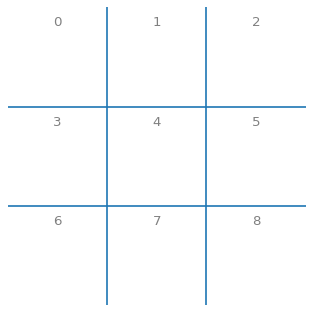

[[0, 0.0],
 [1, 0.0],
 [2, 0.0],
 [3, 0.0],
 [4, 0.0],
 [5, 0.0],
 [6, 0.0],
 [7, 0.0],
 [8, 0.0]]

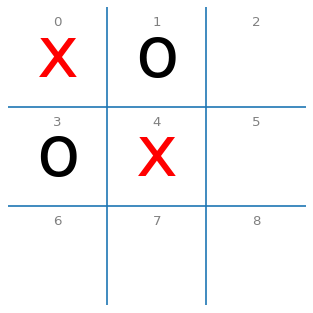

[[2, 0.18], [5, 0.0], [6, nan], [7, 0.21], [8, 1]]

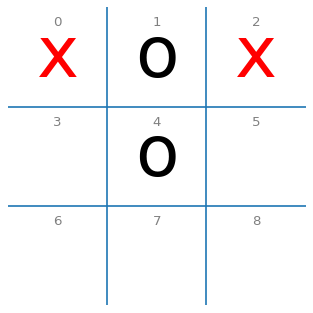

[[3, -1], [5, -1], [6, -1], [7, 0.0], [8, -1]]

In [120]:
Q = qplayer_x.Q

def find_q(s):
    return [[x, round(Q.get((tuple(s), x), np.nan),2)] for x in actions(s)]


board = empty_board()
show_board(board)
display(find_q(board))


board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'
show_board(board)
display(find_q(board))


board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
board[4] = 'o'
show_board(board)
display(find_q(board))